In [4]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['LiSong Pro Light']
plt.rcParams['font.serif'] = ['LiSong Pro Light']
plt.rcParams['axes.unicode_minus']=False
import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['LiSong Pro Light', 'Helvetica']})
pd.options.display.max_rows=200
pd.options.display.max_colwidth = 300
%config InlineBackend.figure_format = 'retina'

In [2]:

import requests
responses = []
import requests
for i in range(0, 3282//30):
    cookies = {
        'urlJumpIp': '1',
        'urlJumpIpByTxt': '%E5%8F%B0%E5%8C%97%E5%B8%82',
        'T591_TOKEN': '20q09qa7igibkfq33brmg9qmq7',
        'webp': '1',
        'PHPSESSID': '352p0k02ndodjhojd7r89uv4d3',
        'good_house_pop': '1',
        'tw591__privacy_agree': '1',
        'XSRF-TOKEN': 'eyJpdiI6InZKdW93OFJUdVhXcTBcL25HMDQ3NEFnPT0iLCJ2YWx1ZSI6IlE0VGx2SDJjRkh2dXFhNkpxSWtMdWZKNGdJeStnT3VTMnBQcEFuR09tb0xsbXNJY1FEOUNCamttQ2IyRDVRSWZHQkRyTGlYUGNkT0pTcmJsXC9MZjR4dz09IiwibWFjIjoiMTNjY2ZkNzc2NWRlM2E1ZDVjYmMwMDJmMGQ3MGZhYzllMWYzMWY2NDc0N2YyYTc3ZGFiNWZkZDEyMzhkNzY4YyJ9',
        '591_new_session': 'eyJpdiI6IkVOOWZWVFpJSVwvekVIZ0pRMkRPUWR3PT0iLCJ2YWx1ZSI6InJVNFlMUzJhMzFrUnZ1aGE1bkNEOUE0bEUycmxLZEVuTFwvc2h0WGZWYVwvNEtVT0piTmFtKyswSWdXM3djNGh6c3BLdEE3YmRyN3JNYVhKem5yQ29kQXc9PSIsIm1hYyI6IjFhNmY4MGZmNDc0MTM1ZGYwNzNhMTNiYzY3NjY2Y2RiYjRkOWRlMTNjYTM2MzhjZGE0MWExYzRhNGVkZjM4ZDMifQ%3D%3D',
    }

    headers = {
        'Connection': 'keep-alive',
        'Accept': 'application/json, text/javascript, */*; q=0.01',
        'DNT': '1',
        'X-CSRF-TOKEN': 'E6SUOSuOZAFVRTAMpDG6eAKacw7NgoH9lPtiMFfW',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.122 Safari/537.36',
        'X-Requested-With': 'XMLHttpRequest',
        'Sec-Fetch-Site': 'same-origin',
        'Sec-Fetch-Mode': 'cors',
        'Sec-Fetch-Dest': 'empty',
        'Referer': 'https://sale.591.com.tw/?shType=list&regionid=1&area=60_&price=4000_',
        'Accept-Language': 'en-US,en;q=0.9,fr;q=0.8,zh-TW;q=0.7,zh;q=0.6,zh-CN;q=0.5,is;q=0.4',
    }

    params = (
        ('type', '2'),
        ('shType', 'list'),
        ('regionid', '1'),
        ('price', '4000_'),
        ('area', '60_'),
        ('firstRow', f'{30*i}'),
        ('totalRows', '3282'),
        ('timestamp', '1587868685151'),
    )

    response = requests.get('https://sale.591.com.tw/home/search/list', headers=headers, params=params, cookies=cookies)
    responses.append(response.text)
print(f'responses: {len(responses)}')

#NB. Original query string below. It seems impossible to parse and
#reproduce query strings 100% accurately so the one below is given
#in case the reproduced version is not "correct".
# response = requests.get('https://sale.591.com.tw/home/search/list?type=2&shType=list&regionid=1&price=4000_&area=60_&firstRow=0&totalRows=3365&timestamp=1586588494377', headers=headers, cookies=cookies)


responses: 109


In [10]:
import json

responses_parsed = []
for r in responses:
    responses_parsed.append(json.loads(r))

import datetime
date = datetime.date.today().strftime('%Y-%m-%d')

with open(f'all_responses_parsed_{date}.json', 'w') as json_file:
    json.dump(responses_parsed, json_file)

houses = []
for r in responses_parsed:
    if 'data' in r:
        if 'house_list' in r['data']:
            for house in r['data']['house_list']:
                houses.append(house)

df = pd.DataFrame(houses)

def get_link(houseid):
    return f'https://sale.591.com.tw/home/house/detail/2/{houseid}.html'
df['link'] = df['houseid'].apply(get_link)

df.unit_price = df.unit_price.apply(lambda s : float(str(s).replace('萬/坪','')))


def extract_floor(f):
    try:
        return float(f.split('/')[0].replace('F',''))
    except:
        return np.NaN
df['floor_f'] = df.floor.apply(extract_floor)

df['floor_q'] = pd.qcut(df.floor_f, 5, labels=["very low","low", "medium", "high", "very high"])
df['age_q'] = pd.qcut(df.houseage, 3, labels=["low", "medium", "high"])
df['size_q'] = pd.qcut(df.mainarea, 3, labels=["low", "medium", "high"])

def translate_section(x):
    translations ={'北投區':'Beitou', '松山區':'Songshan',
     '中正區':'ZhongZheng', '中山區':'Zhongshan',
     '大安區':'Daan', '內湖區':'Neihu',
     '士林區':'Shilin', '信義區':'Xhinyi', '文山區':'WenShan',
       '大同區':'Datong', '萬華區':'Wanhua', '南港區':'NanGang'}
    if x in translations:
        return translations[x]
    return 'n/a'

df['section_name_en'] = df.section_name.apply(translate_section)
df['date'] = date
df.to_csv(f'houses_taipei_40M_{date}.csv')

df.to_pickle(f'houses_taipei_40M_{date}.pkl')

In [11]:
df = pd.read_pickle(f'houses_taipei_40M_{date}.pkl')

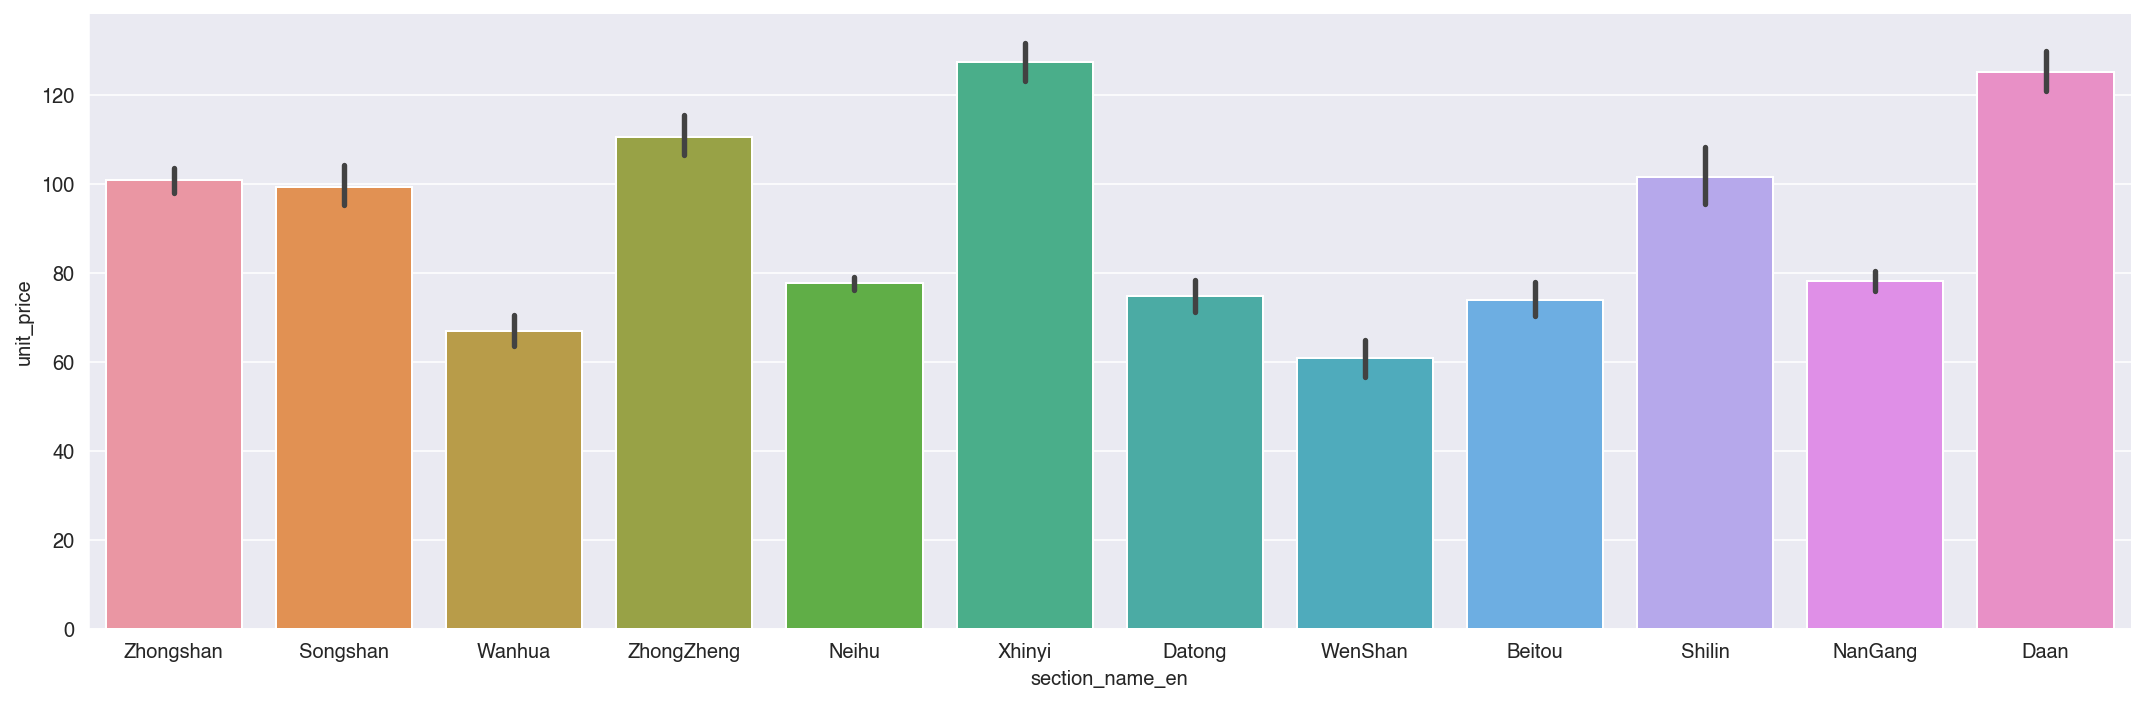

In [8]:
#sns.set_style("darkgrid",{"font.sans-serif":['LiSong Pro', 'Helvetica']})
sns.catplot(data=df, y='unit_price', kind='bar', x='section_name_en',aspect=3)

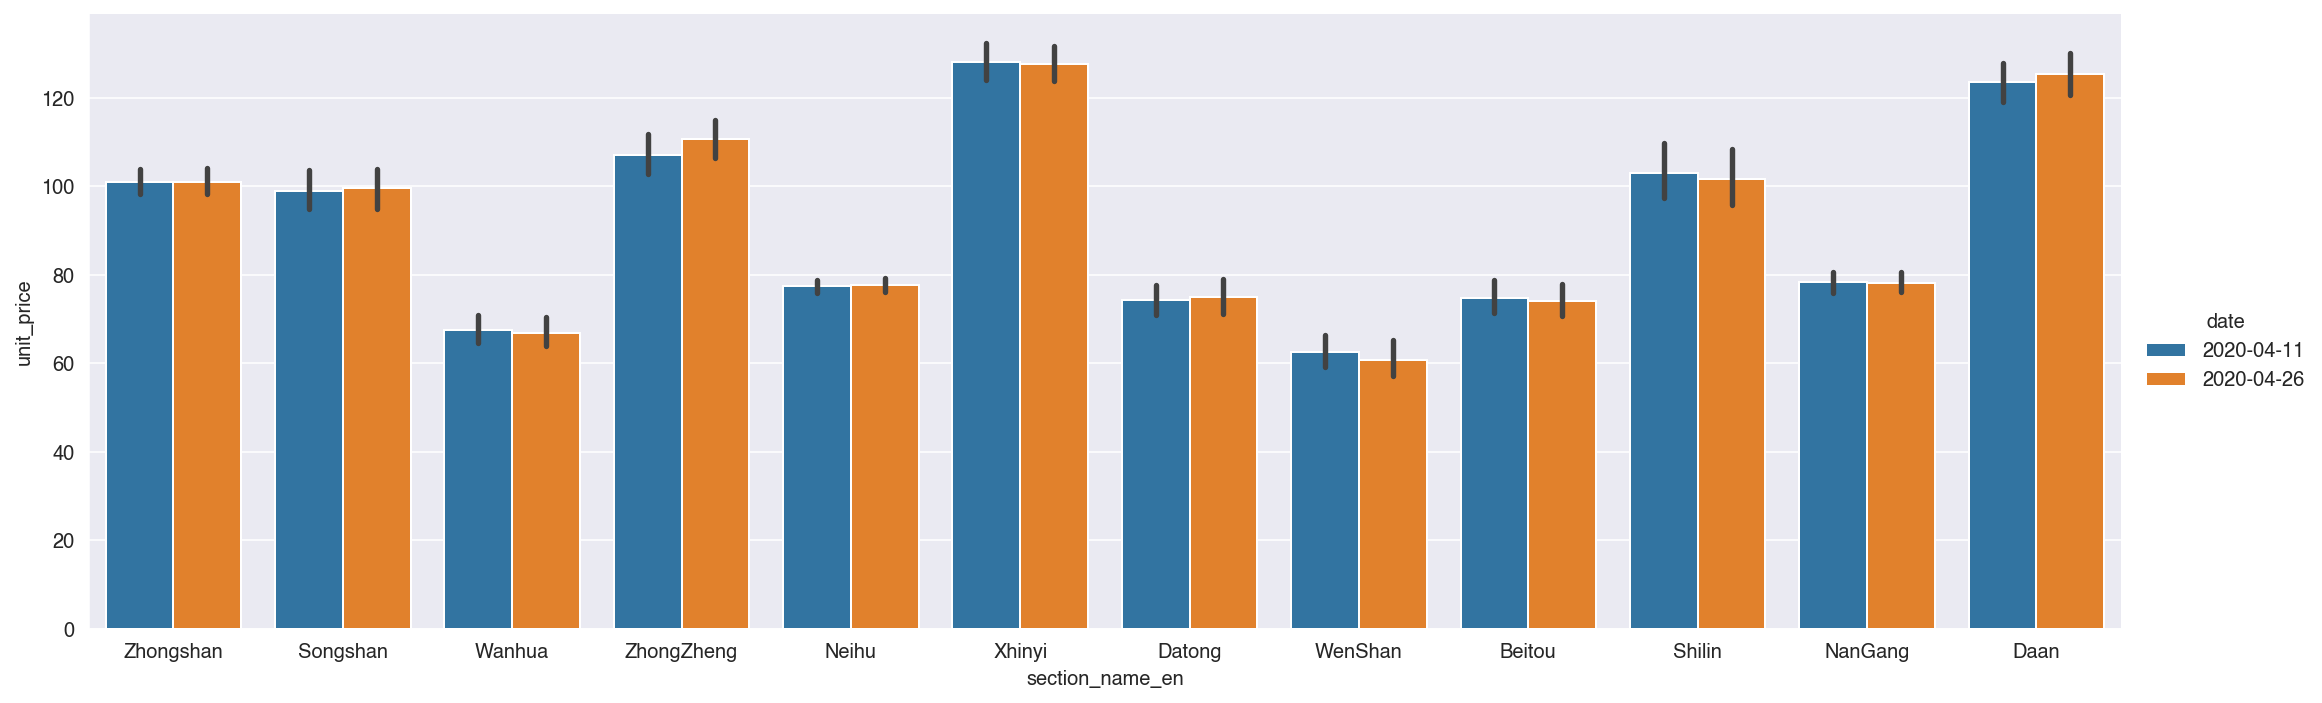

In [15]:
#sns.set_style("darkgrid",{"font.sans-serif":['LiSong Pro', 'Helvetica']})
sns.catplot(data=df_b, y='unit_price', kind='bar', x='section_name_en',
            hue='date',aspect=3,hue_order=sorted(df_b.date.unique()))cv

In [18]:
df_b.groupby('date')['unit_price'].describe()

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
2020-04-11,3300.0,98.418903,42.245747,10.42,72.3675,87.94,113.1350,461.42
2020-04-26,3270.0,98.399526,43.254344,1.00,72.2375,87.15,113.3125,534.40


In [23]:
first_date = sorted(df_b.date.unique())[0]
curr_date = sorted(df_b.date.unique())[-1]
first_prc = df_b[df_b.date == first_date].unit_price.mean()
curr_prc = df_b[df_b.date == curr_date].unit_price.mean()
prc_chg = 100.  * (curr_prc -  first_prc) / first_prc
print(f'price change from {first_date} to {curr_date}: {prc_chg:.3f}%')

price change from 2020-04-11 to 2020-04-26: -0.020%


In [9]:
df_old = pd.read_pickle('houses_taipei_40M_2020-04-11.pkl')

In [12]:
df_old['date'] = '2020-04-11'

In [13]:
df_b=pd.concat([df,df_old],ignore_index=True)

In [ ]:
g = sns.FacetGrid(df[df.section_name_en == 'Datong'], x="time",  row="smoker")
g = g.map(plt.scatter, "total_bill", "tip", edgecolor="w")
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)

In [78]:
df.groupby('floor_q').floor_f.describe()

,count,mean,std,min,25%,50%,75%,max
floor_q,,,,,,,,
very low,662.0,2.006042,0.760181,1.0,1.0,2.0,3.0,3.0
low,509.0,4.540275,0.498866,4.0,4.0,5.0,5.0,5.0
medium,801.0,7.561798,1.172173,6.0,7.0,7.0,9.0,9.0
high,324.0,10.472222,0.500000,10.0,10.0,10.0,11.0,11.0
very high,573.0,15.507853,3.436032,12.0,13.0,14.0,17.0,40.0


In [64]:
df.groupby('size_q').mainarea.describe()

,count,mean,std,min,25%,50%,75%,max
size_q,,,,,,,,
low,1100.0,21.031018,15.780720,0.00,0.000,30.75,33.9075,35.69
medium,1101.0,41.997829,4.330581,35.70,38.220,41.10,45.9300,50.41
high,1099.0,74.833813,31.615508,50.49,55.365,66.08,79.3800,304.87


In [87]:
df.groupby('age_q').houseage.describe()

,count,mean,std,min,25%,50%,75%,max
age_q,,,,,,,,
low,1192.0,4.083054,2.154171,0.0,2.0,4.0,6.0,7.0
medium,1039.0,11.152069,2.429740,8.0,9.0,11.0,13.0,16.0
high,1085.0,31.325346,10.768366,17.0,22.0,31.0,38.0,125.0


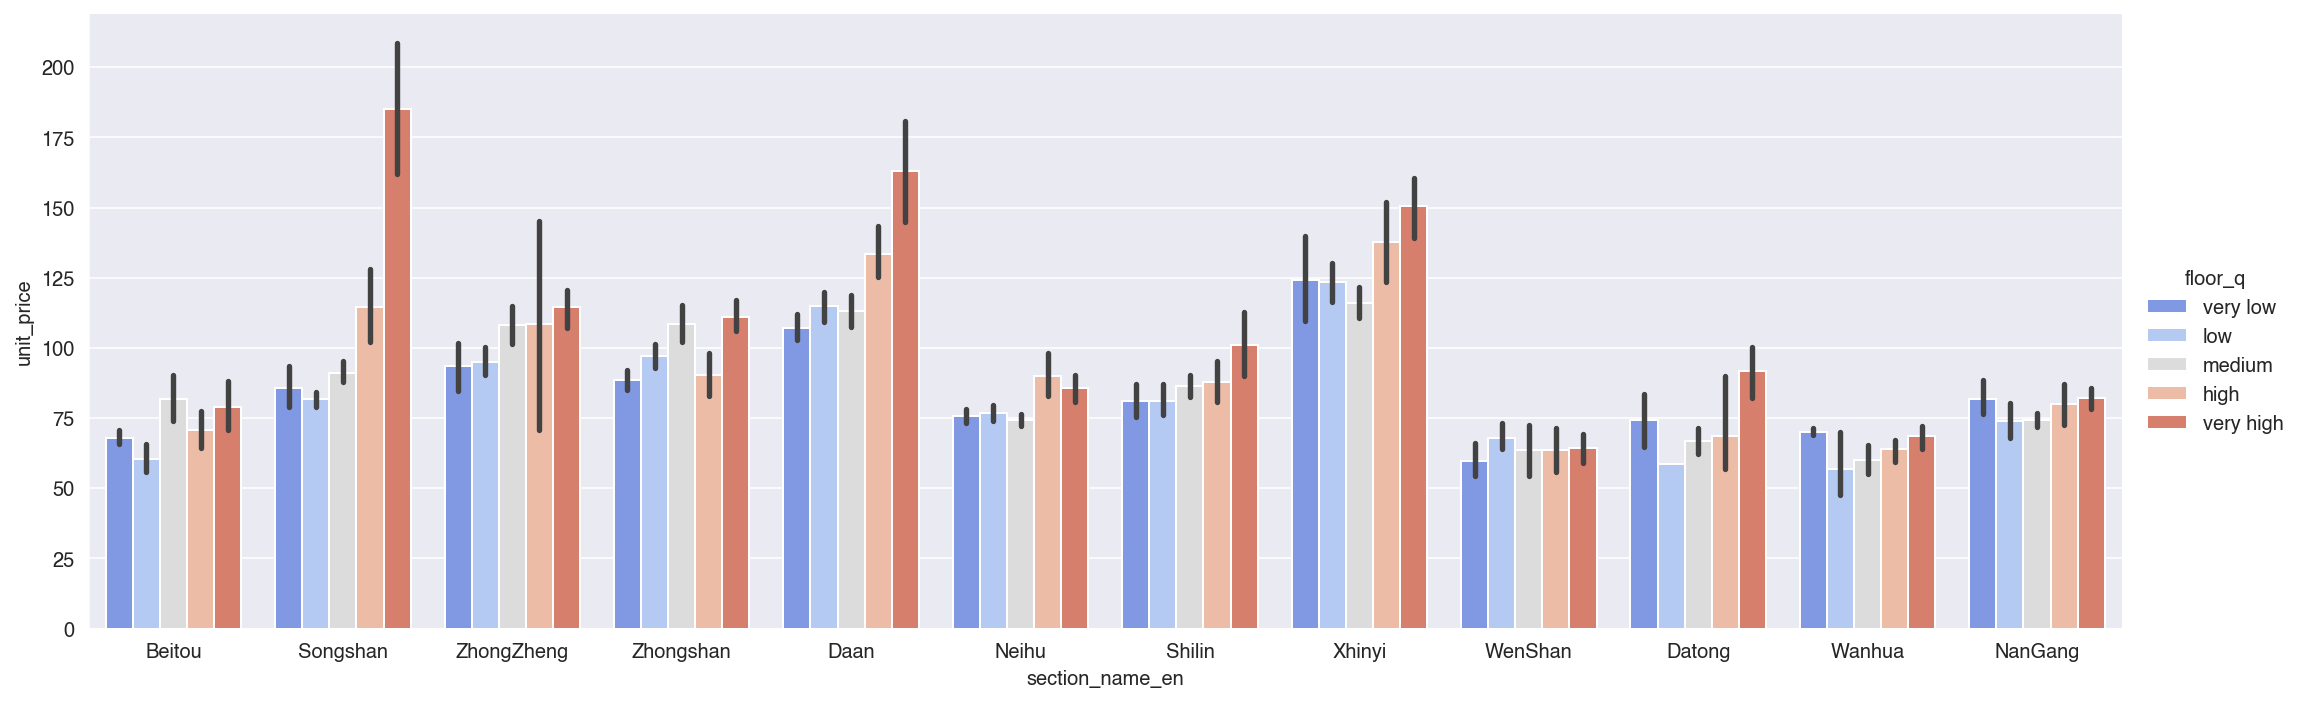

In [80]:
#sns.set_style("darkgrid",{"font.sans-serif":['LiSong Pro', 'Helvetica']})
g = sns.catplot(data=df, kind='bar', x='section_name_en',hue='floor_q',y='unit_price',aspect=3, palette='coolwarm')


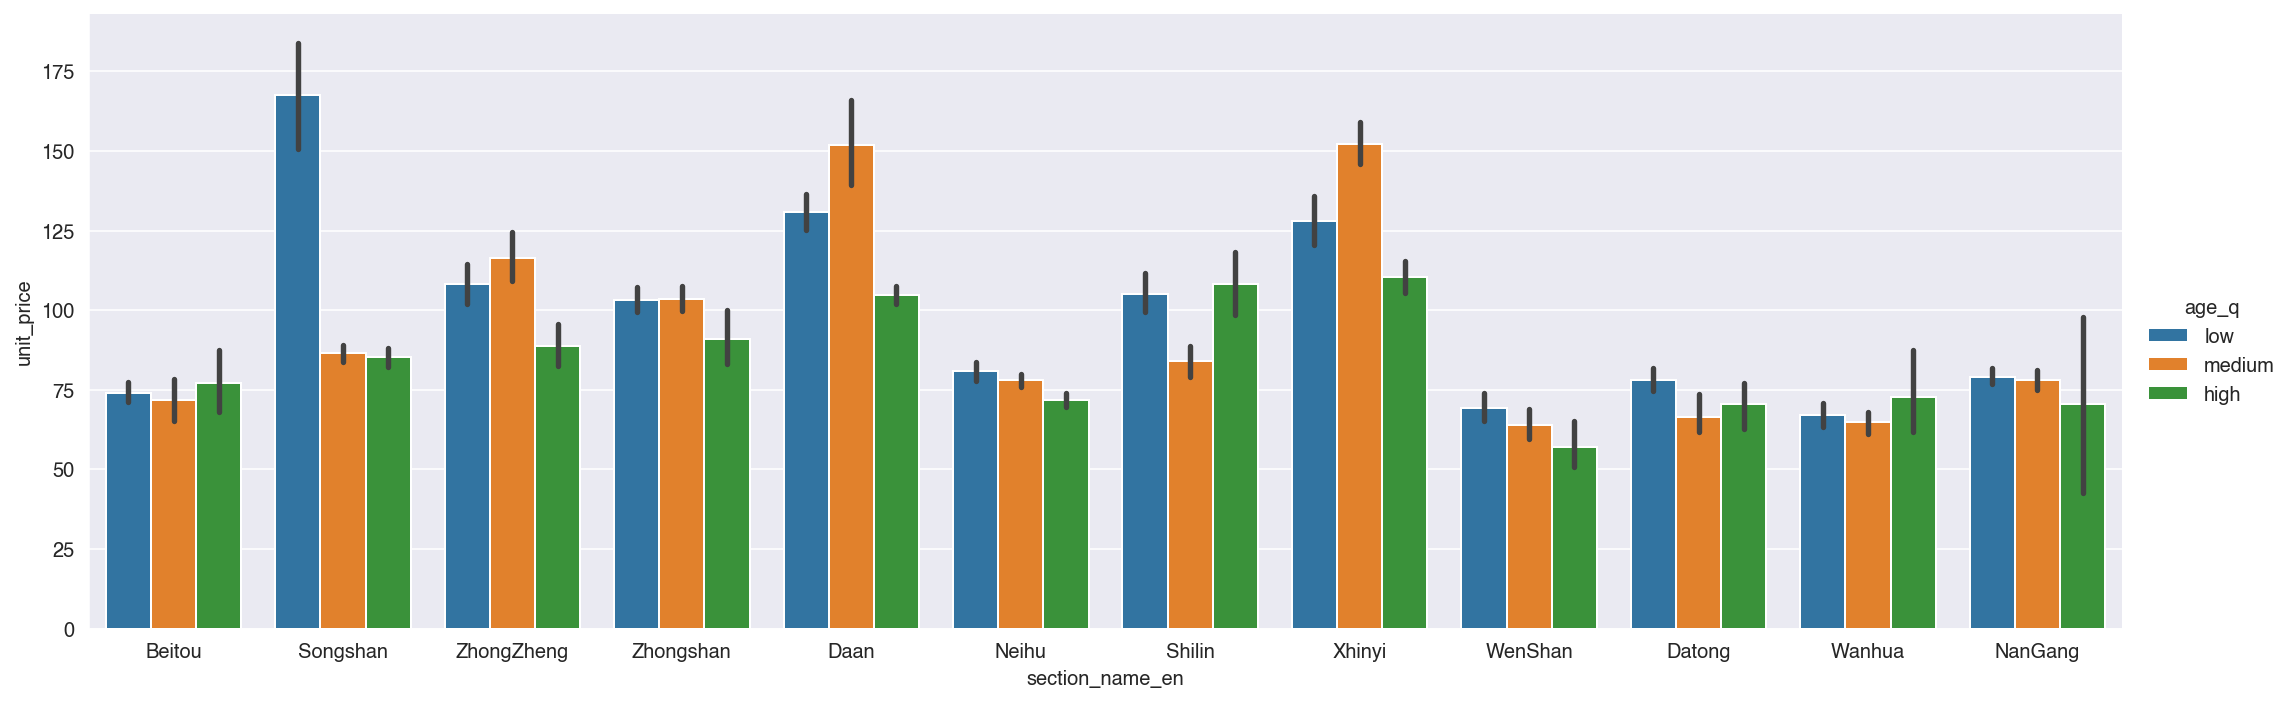

In [74]:
#sns.set_style("darkgrid",{"font.sans-serif":['LiSong Pro', 'Helvetica']})
g = sns.catplot(data=df, kind='bar', x='section_name_en',hue='age_q',y='unit_price',aspect=3)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)

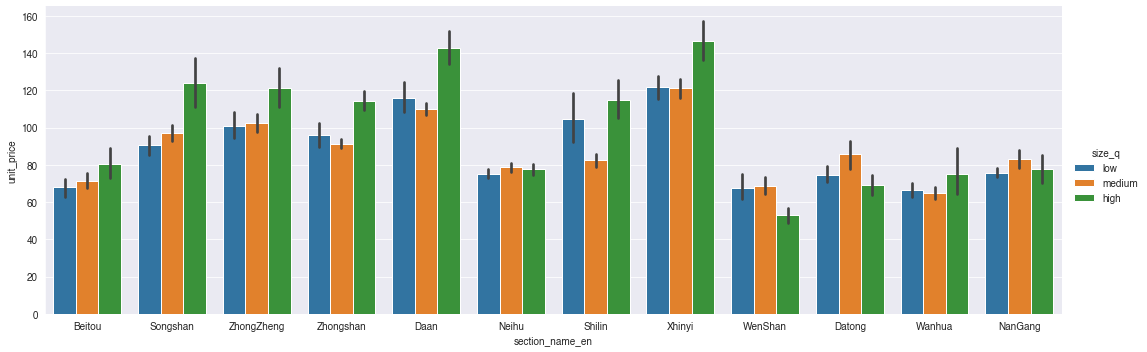

In [71]:
#sns.set_style("darkgrid",{"font.sans-serif":['LiSong Pro', 'Helvetica']})
g = sns.catplot(data=df, kind='bar', x='section_name_en',hue='size_q',y='unit_price',aspect=3)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)

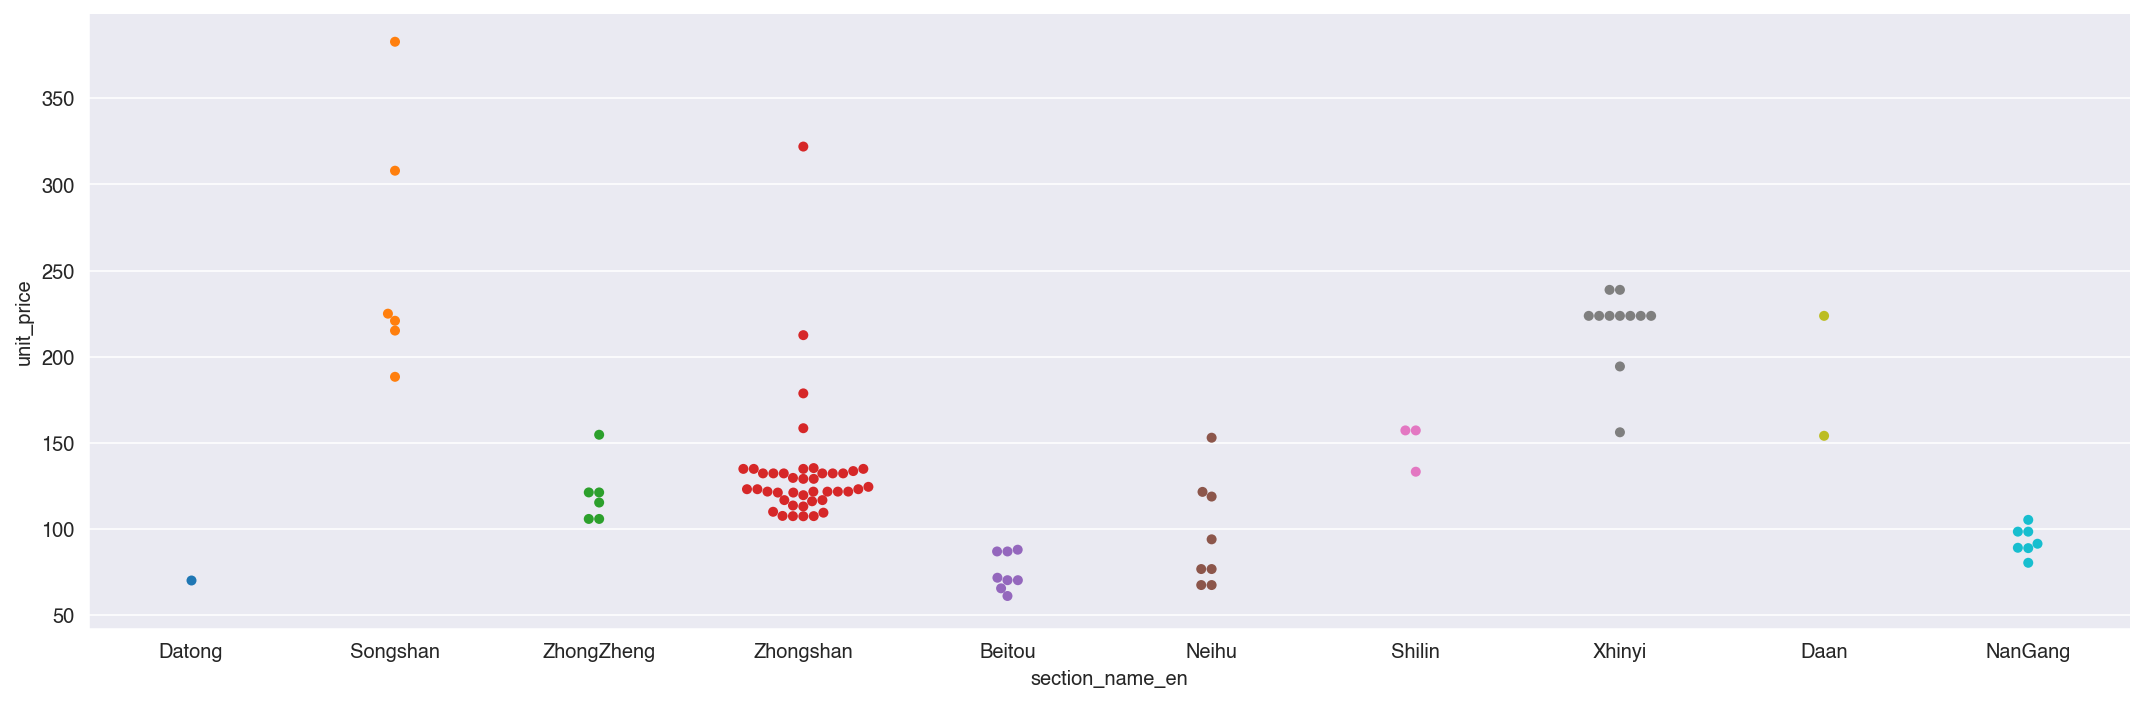

In [86]:
g = sns.catplot(data=df[(df.floor_q == 'very high') & (df.age_q == 'low') & (df.size_q == 'high')],y='unit_price', kind='swarm', x='section_name_en',aspect=3)

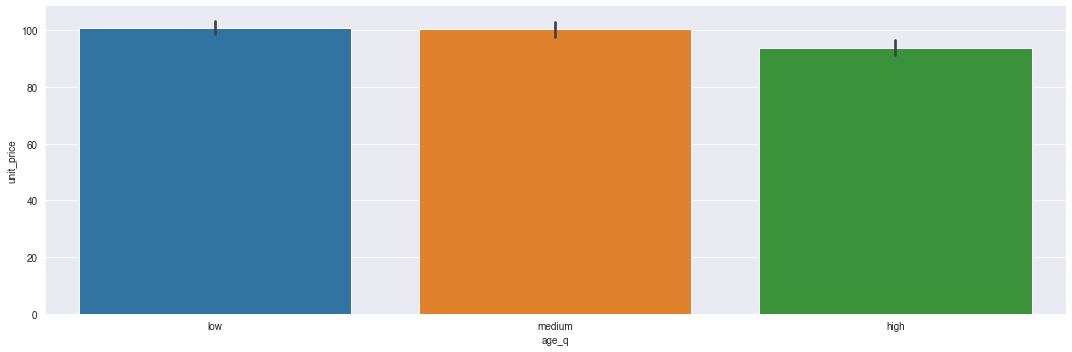

In [61]:
#sns.set_style("darkgrid",{"font.sans-serif":['LiSong Pro', 'Helvetica']})
g = sns.catplot(data=df, kind='bar', x='age_q',y='unit_price',aspect=3)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)

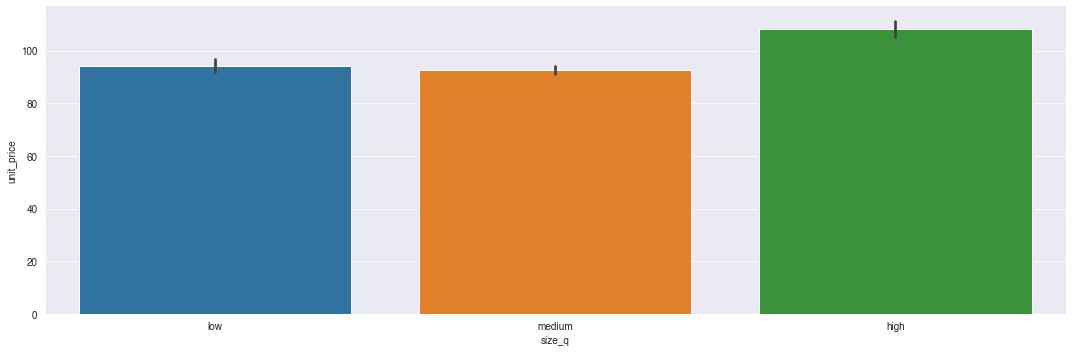

In [62]:
#sns.set_style("darkgrid",{"font.sans-serif":['LiSong Pro', 'Helvetica']})
g = sns.catplot(data=df, kind='bar', x='size_q',y='unit_price',aspect=3)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)

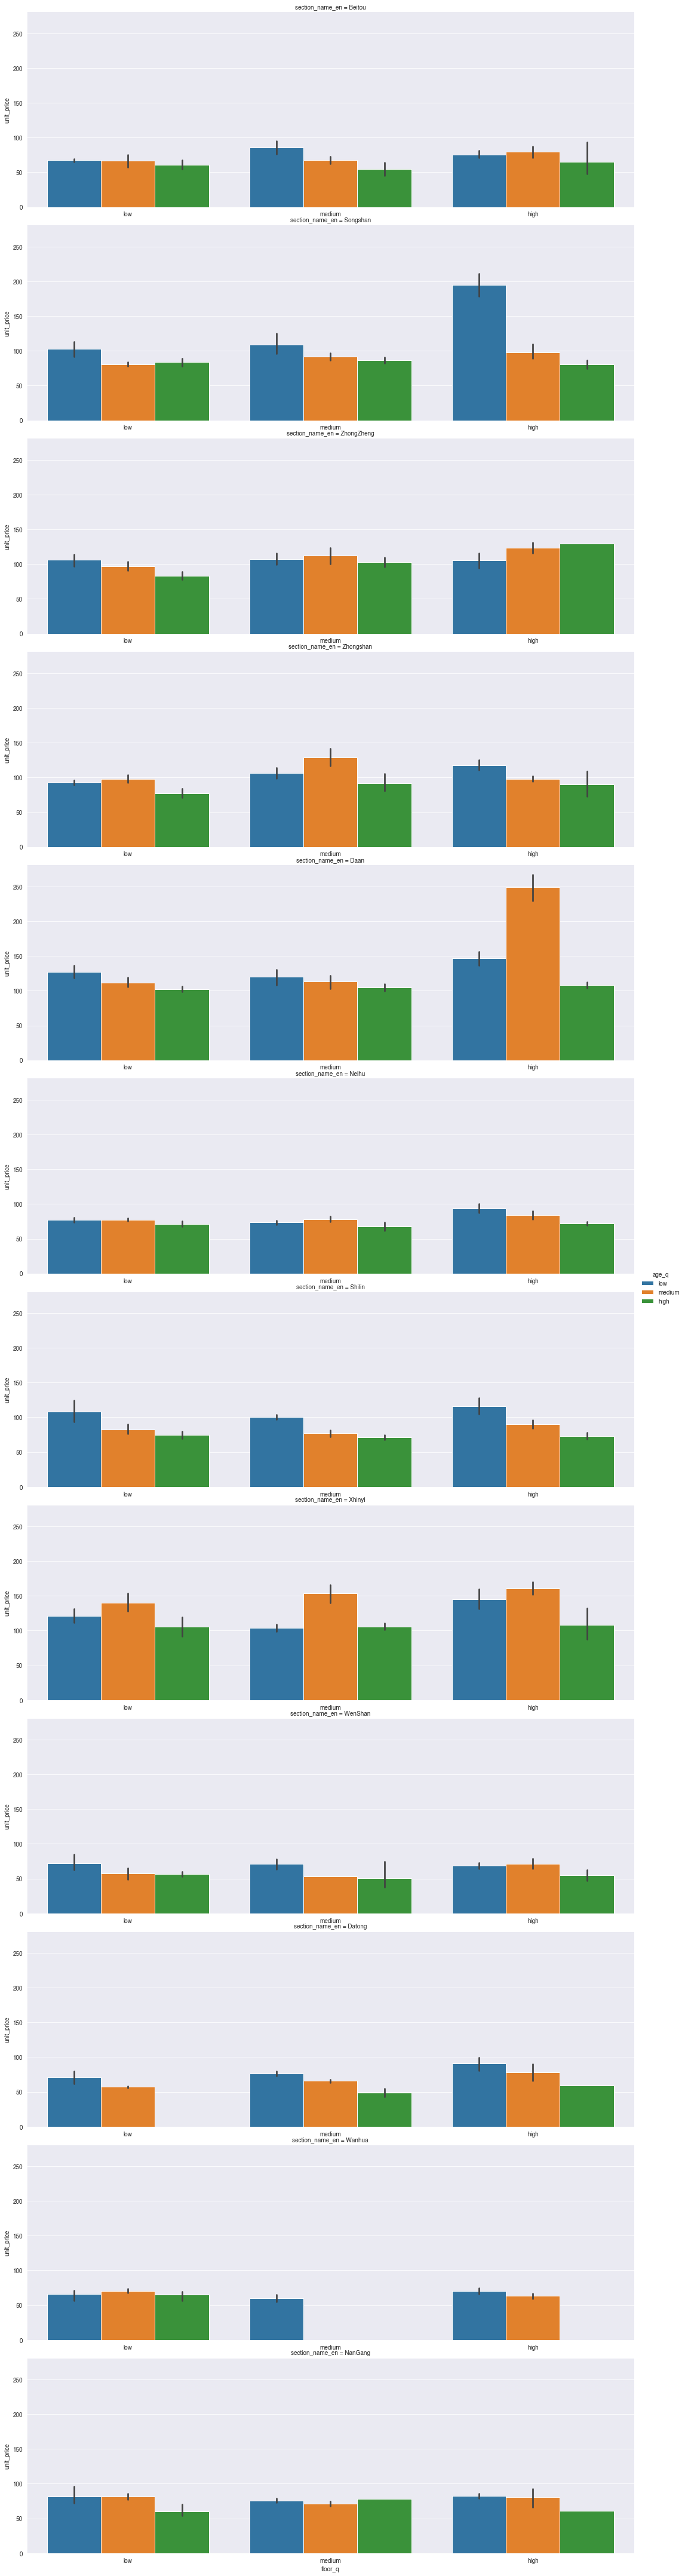

In [39]:
#sns.set_style("darkgrid",{"font.sans-serif":['LiSong Pro', 'Helvetica']})
g = sns.catplot(data=df, kind='bar', x='floor_q',hue='age_q',y='unit_price',aspect=3, row='section_name_en')
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)

In [68]:
df[(df.section_name_en == 'Datong') & (df.floor_q == 'high') & (df.age_q == 'low')][['unit_price','houseage','floor','title','link']]

,unit_price,houseage,floor,title,link
22,70.18,7,14F/15F,與國寶級大廚比鄰而居,https://sale.591.com.tw/home/house/detail/2/7533207.html
28,101.76,2,18F/18F,中山文華高樓景觀屋(編號301),https://sale.591.com.tw/home/house/detail/2/7476105.html
556,89.85,2,18F/18F,中山文華高樓景觀屋,https://sale.591.com.tw/home/house/detail/2/7458830.html
1445,101.76,2,18F/18F,中山文華高樓景觀屋～大家雙連捷運,https://sale.591.com.tw/home/house/detail/2/7553707.html
1534,56.71,5,11F/15F,專任勿擾屋主~迪化旁88正號鼎極全新大戶,https://sale.591.com.tw/home/house/detail/2/7535744.html
1633,89.85,2,18F/18F,中山文華頂極稀有景觀戶,https://sale.591.com.tw/home/house/detail/2/7513138.html
1804,101.76,2,18F/18F,中山文華高樓景觀屋～大家雙連捷運,https://sale.591.com.tw/home/house/detail/2/7549507.html
2598,101.76,2,18F/18F,中山文華高樓景觀屋～大家雙連捷運,https://sale.591.com.tw/home/house/detail/2/7438412.html
2606,102.35,2,18F/18F,E28中山文華捷運景觀屋~住商儀居團隊~,https://sale.591.com.tw/home/house/detail/2/7437189.html


In [94]:
cols=['unit_price','mainarea','houseage','floor','title','link', 'community_name']
df[(df.section_name_en == 'Zhongshan') & (df.floor_q == 'very high') & (df.age_q == 'low')][cols].sort_values(by='unit_price')

,unit_price,mainarea,houseage,floor,title,link,community_name
2458,73.64,33.62,3,12F/13F,🍎一次全看🍎天璽景觀4房坡車★游佳諭,https://sale.591.com.tw/home/house/detail/2/7360406.html,天璽
2864,73.64,0.00,3,12F/13F,♥林宇睿豪宅王子~全球專營天璽美景新四房,https://sale.591.com.tw/home/house/detail/2/7532861.html,天璽
857,74.00,31.22,2,14F/16F,松江南京站·高樓景觀宅～住商維甯,https://sale.591.com.tw/home/house/detail/2/7457239.html,奧斯卡南京
2342,88.07,45.29,5,20F/24F,忠泰味高樓景觀四房,https://sale.591.com.tw/home/house/detail/2/7338052.html,忠泰味
1145,88.07,45.29,6,20F/24F,新👍忠泰WAVE👍住商鍾齊修,https://sale.591.com.tw/home/house/detail/2/7533059.html,忠泰味
844,89.66,33.62,3,12F/13F,住商仁愛光復店~天璽景觀4房車位,https://sale.591.com.tw/home/house/detail/2/7525948.html,
2383,94.70,0.00,7,20F/20F,🏠華威八方帝王戶.隱私性高豪邸坡道平面,https://sale.591.com.tw/home/house/detail/2/7332744.html,華威八方
1389,94.72,36.75,2,14F/16F,專營興富發中山官邸鋼骨豪邸,https://sale.591.com.tw/home/house/detail/2/7520951.html,中山官邸
838,97.18,45.29,6,20F/24F,忠泰建設~忠泰味社區~,https://sale.591.com.tw/home/house/detail/2/7507460.html,忠泰味
2530,98.44,45.19,7,20F/24F,忠泰味高樓景觀極致裝潢立可進住,https://sale.591.com.tw/home/house/detail/2/7553174.html,忠泰味


In [96]:
cols=['unit_price','mainarea','houseage','floor','title','link', 'community_name']
df[(df.section_name_en == 'Datong') & (df.floor_q == 'high') & (df.age_q == 'low')][cols].sort_values(by='unit_price')

,unit_price,mainarea,houseage,floor,title,link,community_name
1534,56.71,58.77,5,11F/15F,專任勿擾屋主~迪化旁88正號鼎極全新大戶,https://sale.591.com.tw/home/house/detail/2/7535744.html,三豐鼎極


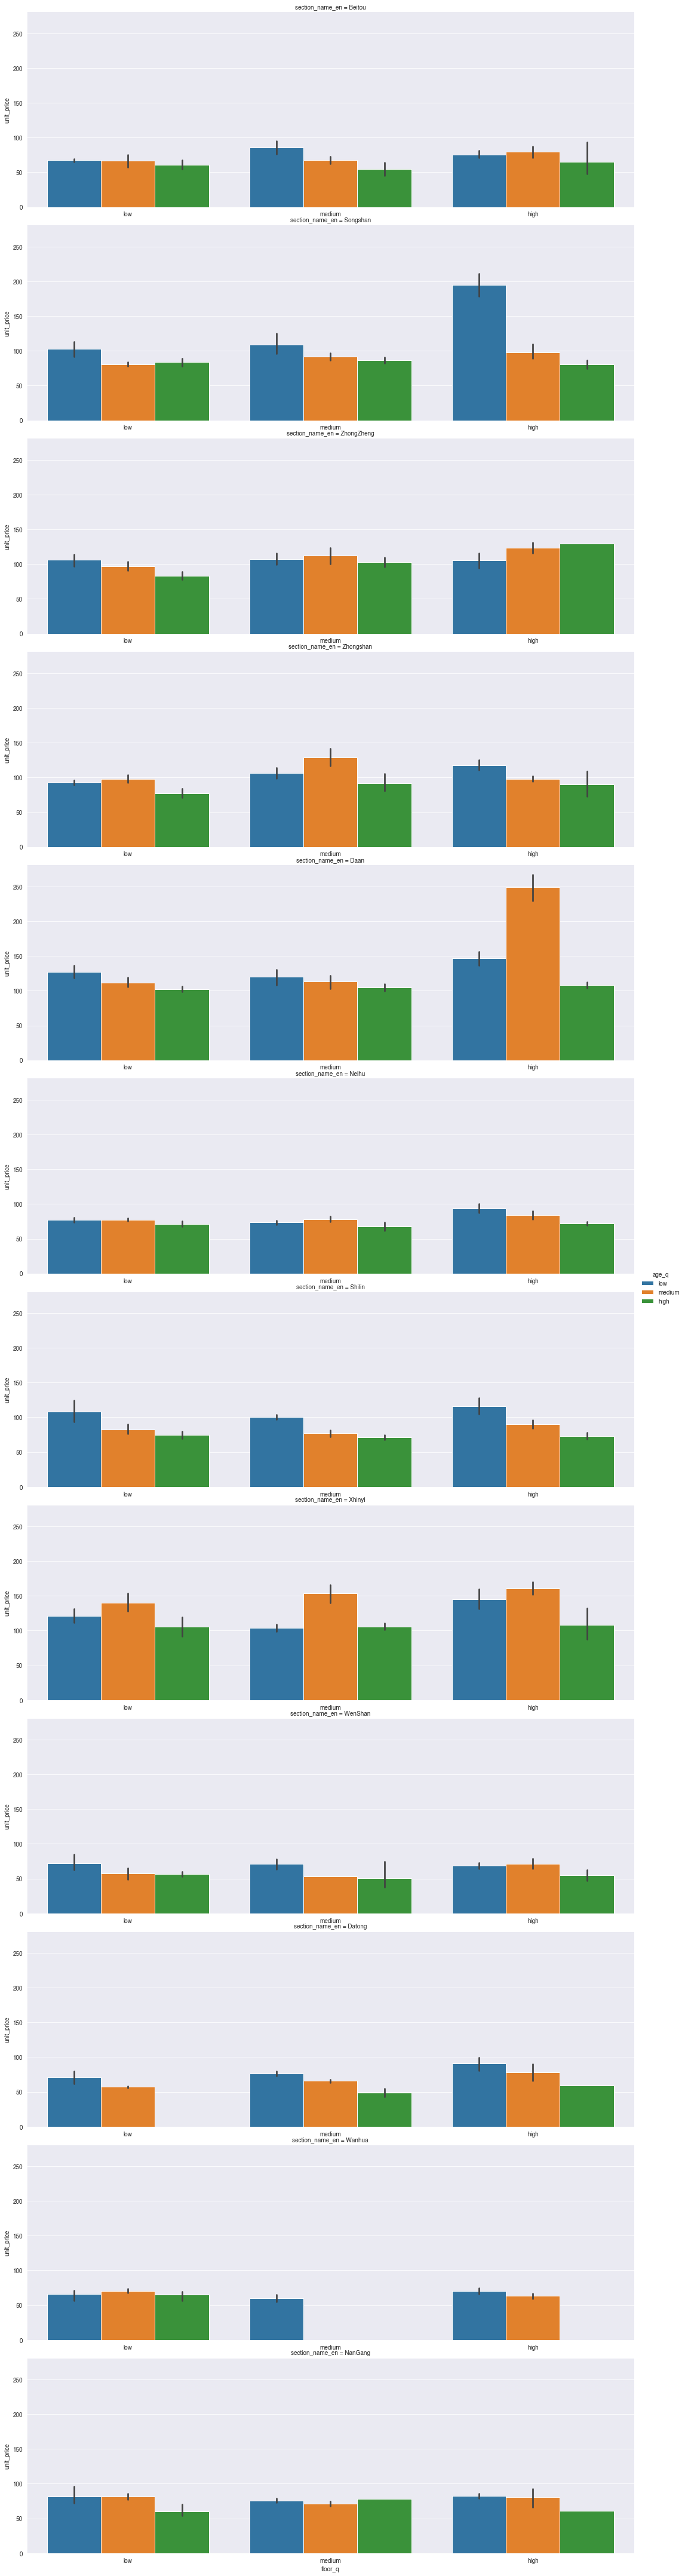

In [39]:
#sns.set_style("darkgrid",{"font.sans-serif":['LiSong Pro', 'Helvetica']})
g = sns.catplot(data=df, kind='bar', x='floor_q',hue='age_q',y='unit_price',aspect=3, row='section_name_en')
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)

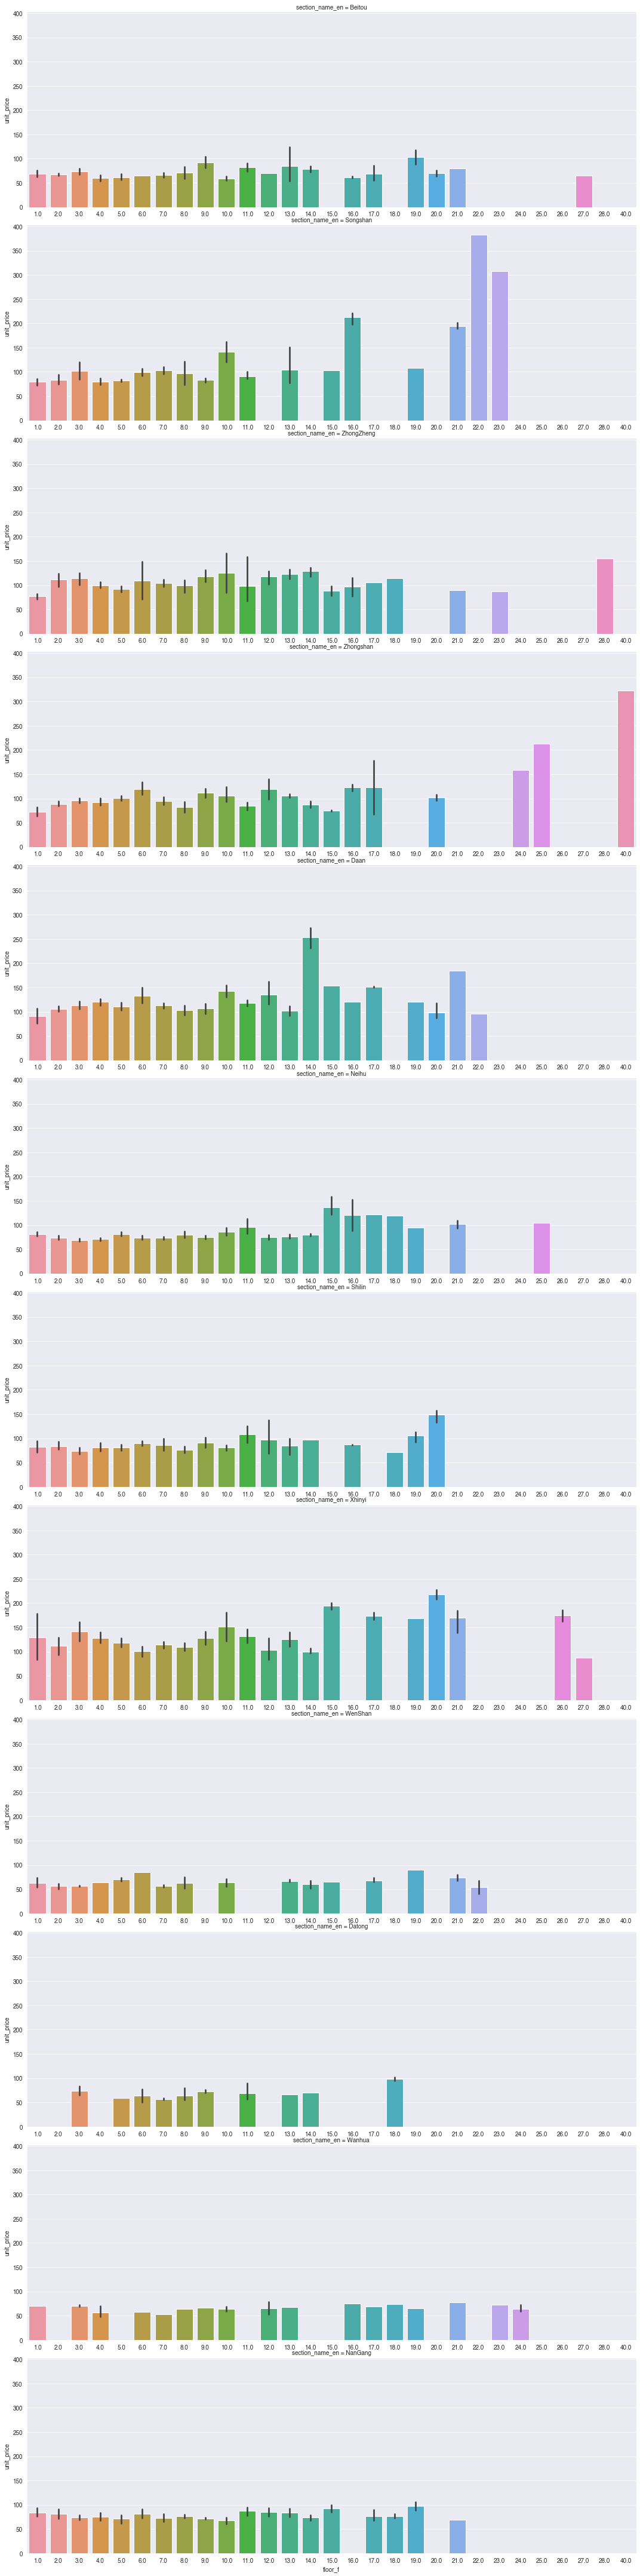

In [32]:
#sns.set_style("darkgrid",{"font.sans-serif":['LiSong Pro', 'Helvetica']})
g = sns.catplot(data=df, y='unit_price', kind='bar', x='floor_f',aspect=3, row='section_name_en')
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)

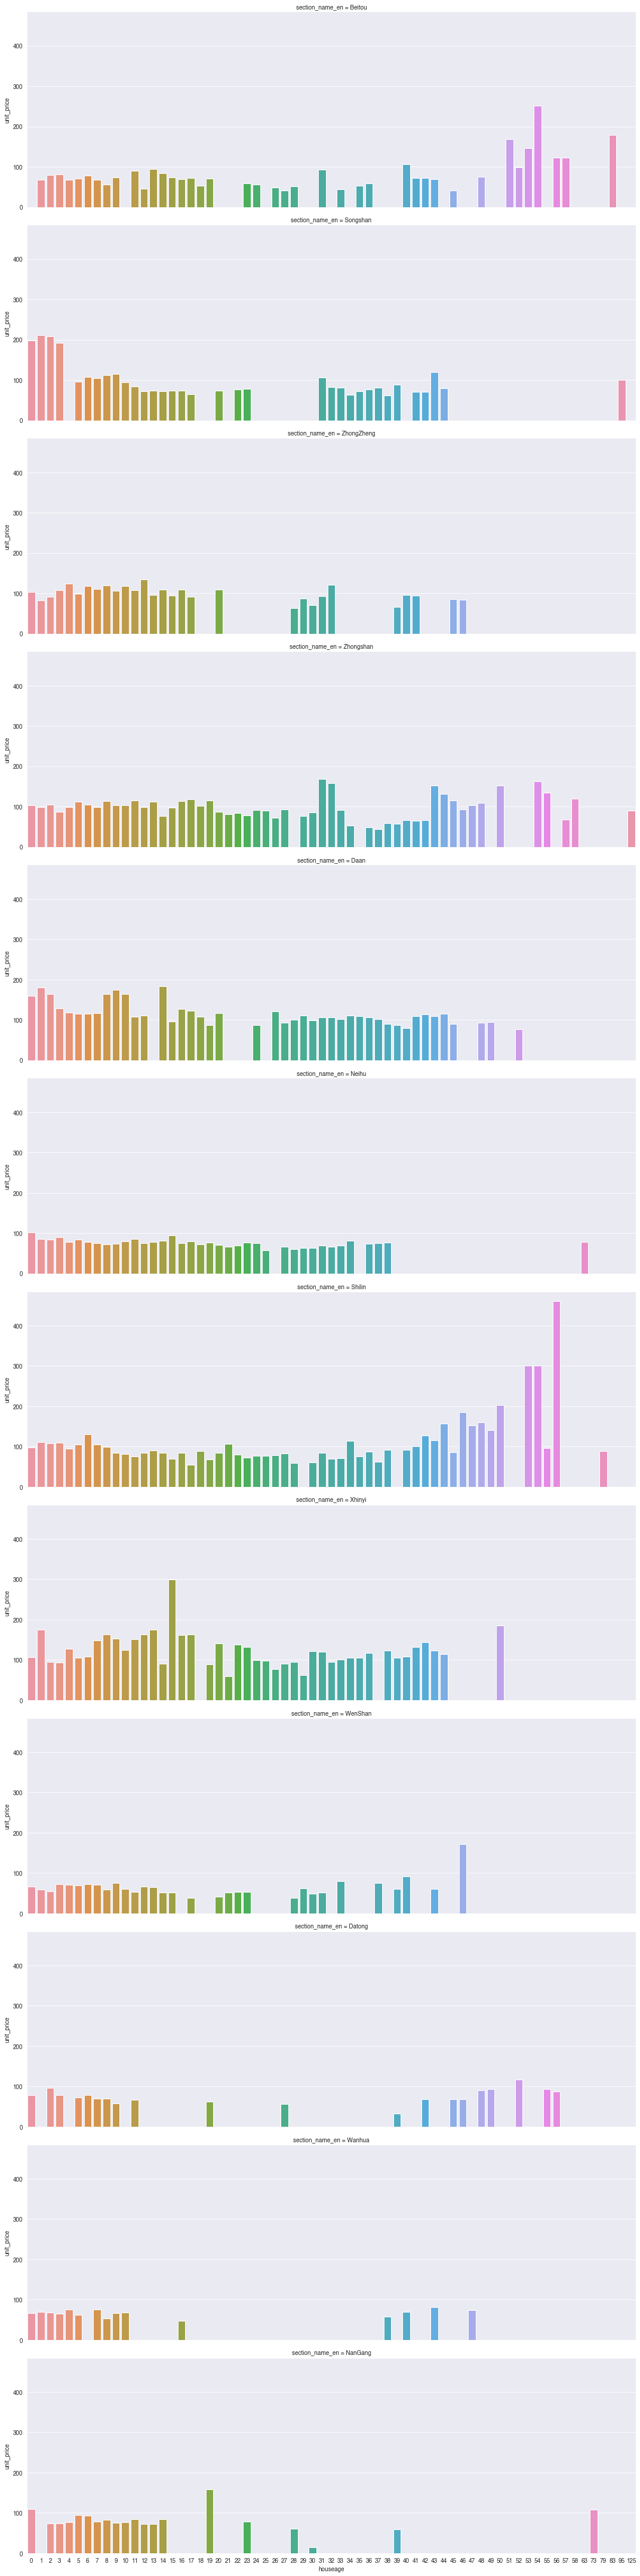

In [17]:
#sns.set_style("darkgrid",{"font.sans-serif":['LiSong Pro', 'Helvetica']})
sns.catplot(data=df, y='unit_price', kind='bar', x='houseage',ci=None,aspect=3, row='section_name_en')